# Mostly stuff from RocketPy examples


In [1]:
import numpy as np
from rocketpy import (
    Function,
    LiquidMotor,
    MassFlowRateBasedTank,
    Fluid,
    Rocket,
    Flight,
    Environment,
    CylindricalTank,
)

In [3]:
# Define an epsilon for numerical stability
eps = 1e-6

## General rocket info


In [31]:
burn_time = 9 # s

rocket_diameter = 152e-3 # m
tank_diameter = 148e-3 # m (inner)
rocket_height = 2950e-3 # m

eth_mass_flow_rate = 0.18207794635498162
lox_mass_flow_rate = 0.29132471416797057

lox_fraction_filled = 0.8
eth_fraction_filled = 0.8

lox_tank_volume = lox_mass_flow_rate * burn_time / 1141 / lox_fraction_filled
eth_tank_volume = eth_mass_flow_rate * burn_time / 789 / eth_fraction_filled

lox_tank_height = lox_tank_volume / (np.pi * tank_diameter**2 / 4) # (650e-3 from first drawing)
eth_tank_height = eth_tank_volume / (np.pi * tank_diameter**2 / 4) # (420e-3 from first drawing)

## Fluids


In [34]:
lox = Fluid(name="LOX", density=1141)
ethanol = Fluid(name="Ethanol", density=789)

# Define pressurizing gases with their respective pressures
lox_tank_pressurizing_gas = Fluid(name="N2", density=31.3 / 28)  # 450 PSI
ethanol_tank_pressurizing_gas = Fluid(
    name="N2", density=313 * 300 / 4500 / 28
)  # 300 PSI
pressurizing_gas = Fluid(name="N2", density=300)  # 4500 PSI

## Tanks


### LOX Tank


In [39]:
lox_tank_geometry = CylindricalTank(tank_diameter/2, lox_tank_height, spherical_caps=False)

lox_tank = MassFlowRateBasedTank(
    name="LOX Tank",
    geometry=lox_tank_geometry,
    flux_time=burn_time,
    initial_liquid_mass=lox_fraction_filled*lox_tank_geometry.total_volume*lox.density*1.001,
    initial_gas_mass=0,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=lox_mass_flow_rate,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=lox,
    gas=lox_tank_pressurizing_gas,
)

### Ethanol Tank


In [42]:
eth_tank_geometry = CylindricalTank(tank_diameter/2, eth_tank_height, spherical_caps=False)

ethanol_tank = MassFlowRateBasedTank(
    name="Ethanol Tank",
    geometry=eth_tank_geometry,
    flux_time=burn_time,
    initial_liquid_mass=eth_fraction_filled*eth_tank_geometry.total_volume*ethanol.density*1.001,
    initial_gas_mass=0,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=eth_mass_flow_rate,
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=ethanol,
    gas=ethanol_tank_pressurizing_gas,
)

In [44]:
#ethanol_tank.fluid_mass()
#ethanol_tank.net_mass_flow_rate()
#ethanol_tank.liquid_height()
#ethanol_tank.gas_height()
#ethanol_tank.center_of_mass()
#ethanol_tank.inertia()

### Pressure Tank


In [47]:
#pressure_tank_geometry = CylindricalTank(0.135 / 2, 0.981, spherical_caps=True)

In [49]:
#pressure_tank = MassBasedTank(
#    name="Pressure Tank",
#    geometry=pressure_tank_geometry,
#    liquid_mass=0,
#    flux_time=(8, 20),
#    gas_mass="../../data/SEBLM/pressurantMassFiltered.csv",
#    gas=pressurizing_gas,
#    liquid=pressurizing_gas,
#)

## Liquid Motor


In [52]:
liquid_motor = LiquidMotor(
    thrust_source=1200,
    center_of_dry_mass_position=0,
    dry_inertia=(0, 0, 0),
    dry_mass=0,
    burn_time=burn_time,
    nozzle_radius=0.04075 / 2,
    nozzle_position=0,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)

liquid_motor.add_tank(ethanol_tank, position=1500e-3)
liquid_motor.add_tank(lox_tank, position=675e-3)
#liquid_motor.add_tank(pressure_tank, position=???)

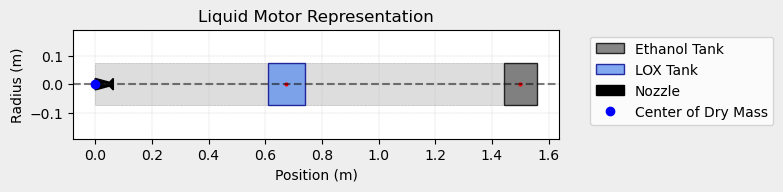

In [54]:
liquid_motor.draw()

## Rocket Definition


In [80]:
void_rocket = Rocket(
    radius=rocket_diameter/2,
    mass=14,
    inertia=(1, 1, 1),
    power_off_drag=0.64,
    power_on_drag=0.64,
    center_of_mass_without_motor=1,
    coordinate_system_orientation="nose_to_tail",
)

void_rocket.add_motor(liquid_motor, position=rocket_height)
nose = void_rocket.add_nose(length=750e-3, kind="vonKarman", position=0)
#tail = void_rocket.add_tail(
#    top_radius=rocket_diameter/2, bottom_radius=rocket_diameter/2*0.7, length=0.198, position=rocket_height - 0.198
#)

fins = void_rocket.add_trapezoidal_fins(
    n=4,
    root_chord=0.355,
    tip_chord=0.0803,
    span=0.156,
    position=rocket_height-0.400,
    cant_angle=0,
)

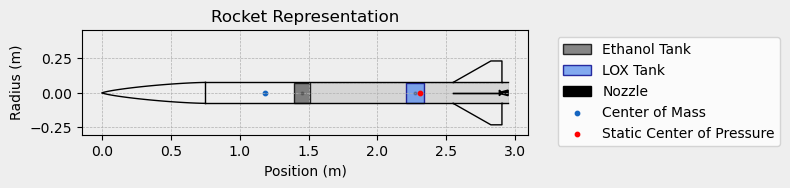

In [82]:
void_rocket.draw()

## Environment


In [85]:
env = Environment(latitude=39.82269076895662, longitude=-8.03993725412526)

env.set_date((2025, 12, 3, 14 + 7, 0, 0))  # UTC

env.set_atmospheric_model(
    type="custom_atmosphere",
    pressure=None,
    temperature=None,
    wind_u=[(0, 1), (500, 0), (1000, 5), (2500, 5.0), (5000, 10)],
    wind_v=[(0, 0), (500, 3), (1600, 2), (2500, -3), (5000, 10)],
)

In [87]:
#env.all_info()

## Flight Simulation


Finally, here we go with our flight simulation.
We are going to run the simulation only until the apogee, since we are not
interested in the landing phase.

The `max_time_step` parameter was set to a low value to ensure there won't be any
numerical instability during the launch rail phase.


In [91]:
test_flight = Flight(
    rocket=void_rocket,
    environment=env,
    rail_length=5,
    inclination=90,
    heading=23,
    #min_time_step=0.00001,
    #max_time_step=0.1,
    terminate_on_apogee=True,
)

In [ ]:
test_flight.

In [74]:
test_flight.apogee

3393.3032038968963


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 0.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.980 | e1: 0.000 | e2: 0.000 | e3: -0.199
Euler Angles - Spin φ : -191.50° | Nutation θ: 0.00° | Precession ψ: 168.50°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 7.385 c


Surface Wind Conditions

Frontal Surface Wind Speed: 0.39 m/s
Lateral Surface Wind Speed: -0.92 m/s


Launch Rail

Launch Rail Length: 5 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 23.00°


Rail Departure State

Rail Departure Time: 0.409 s
Rail Departure Velocity: 24.493 m/s
Rail Departure Stability Margin: 7.441 c
Rail Departure Angle of Attack: 2.316°
Rail Departure Thrust-Weight Ratio: 7.146
Rail Departure Reynolds Number: 2.550e+05


Burn out State

Burn out time: 7.000 s
Altitude at burn out: 1549.254 m (ASL) | 1549.254 m (AGL)
Rocket speed at burn out: 453.878 m/s
Freestream veloc

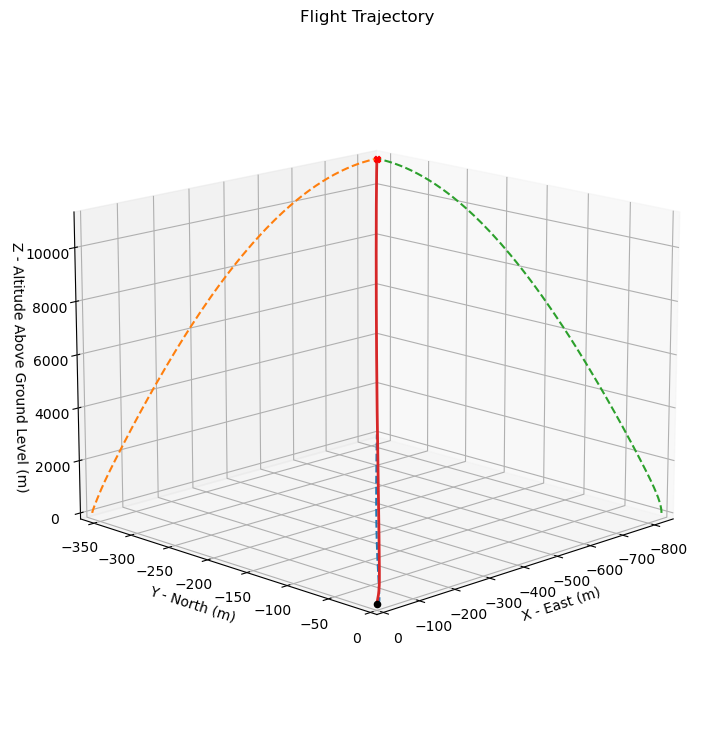



Trajectory Kinematic Plots



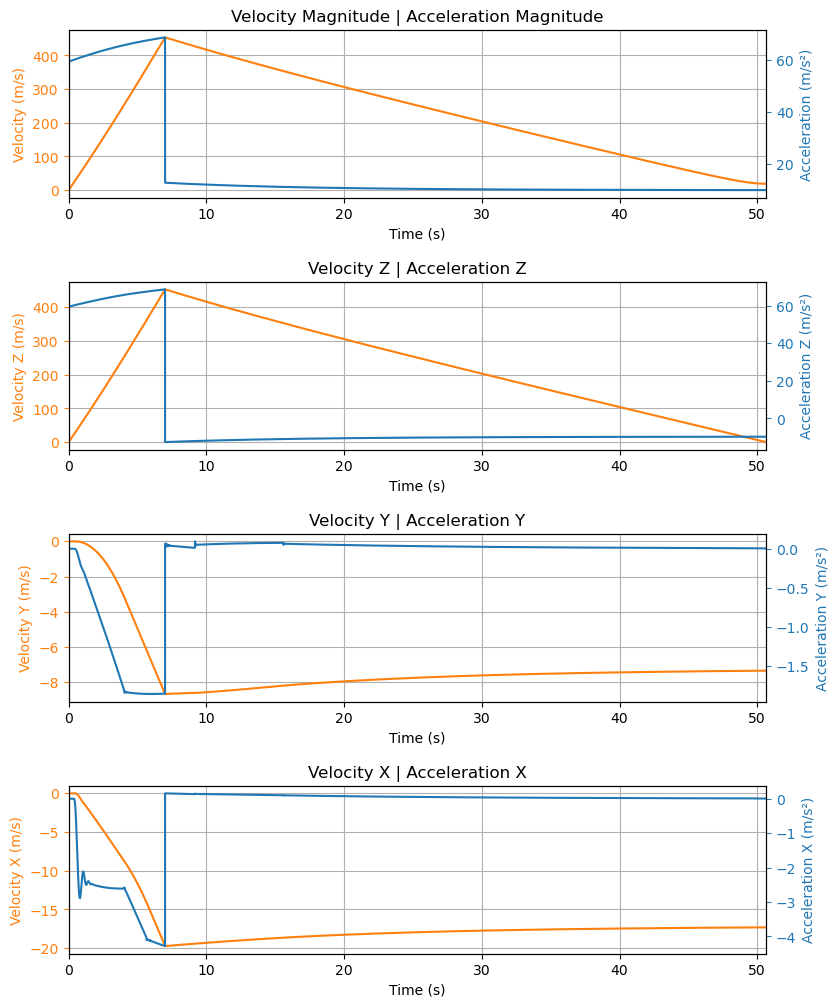



Angular Position Plots



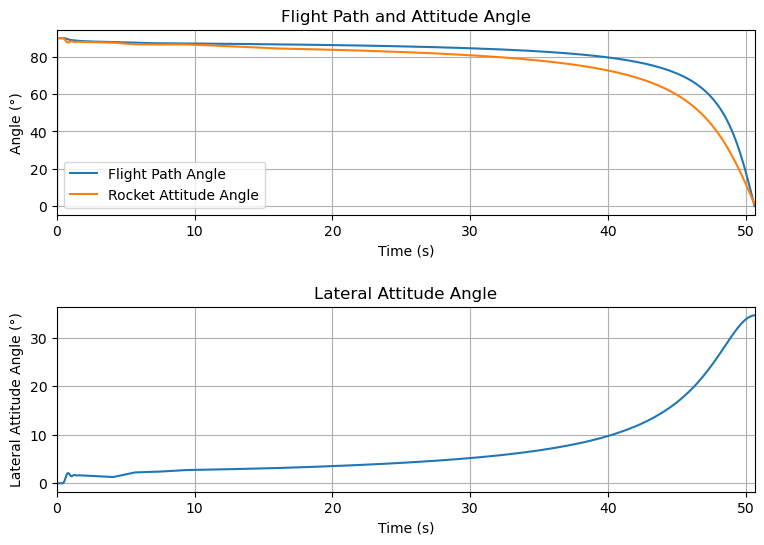



Path, Attitude and Lateral Attitude Angle plots



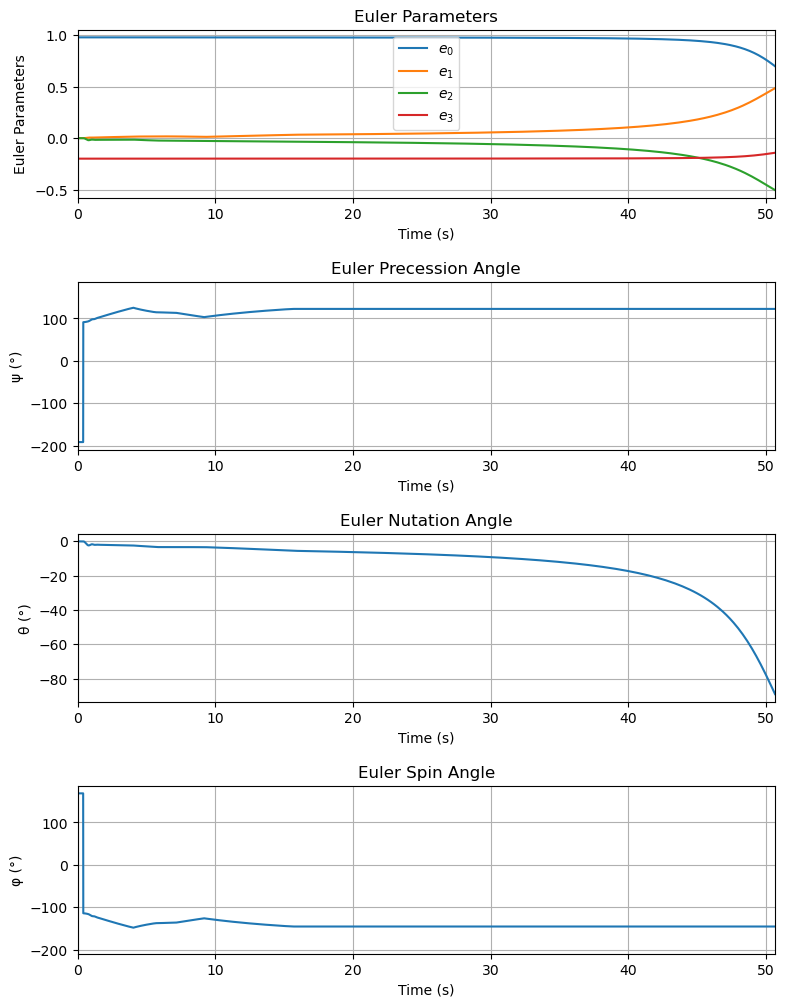



Trajectory Angular Velocity and Acceleration Plots



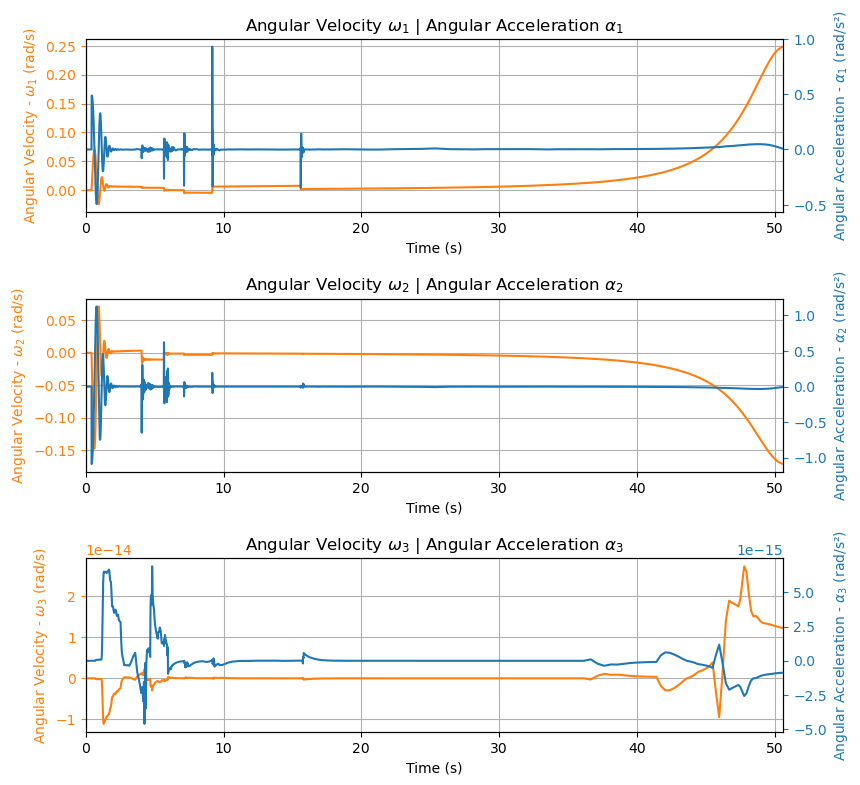



Aerodynamic Forces Plots



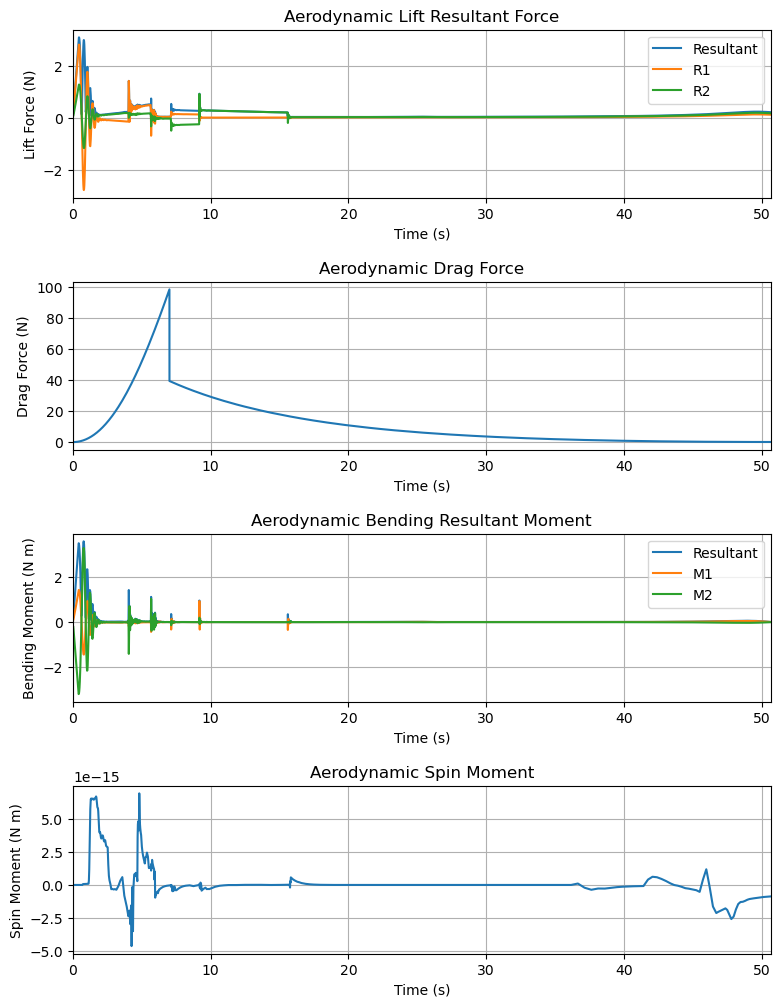



Rail Buttons Forces Plots

No rail buttons were defined. Skipping rail button plots.


Trajectory Energy Plots



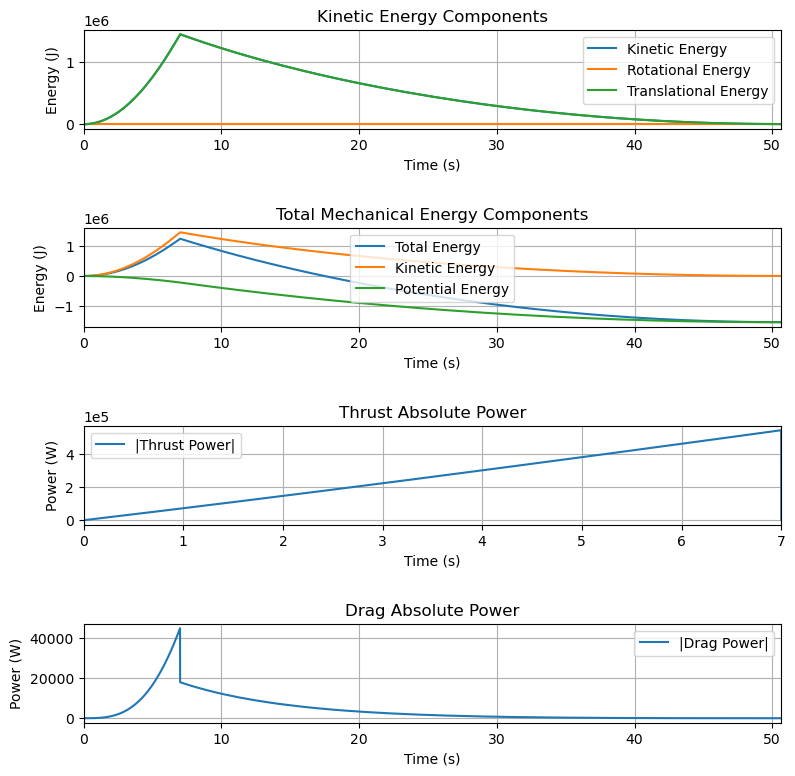



Trajectory Fluid Mechanics Plots



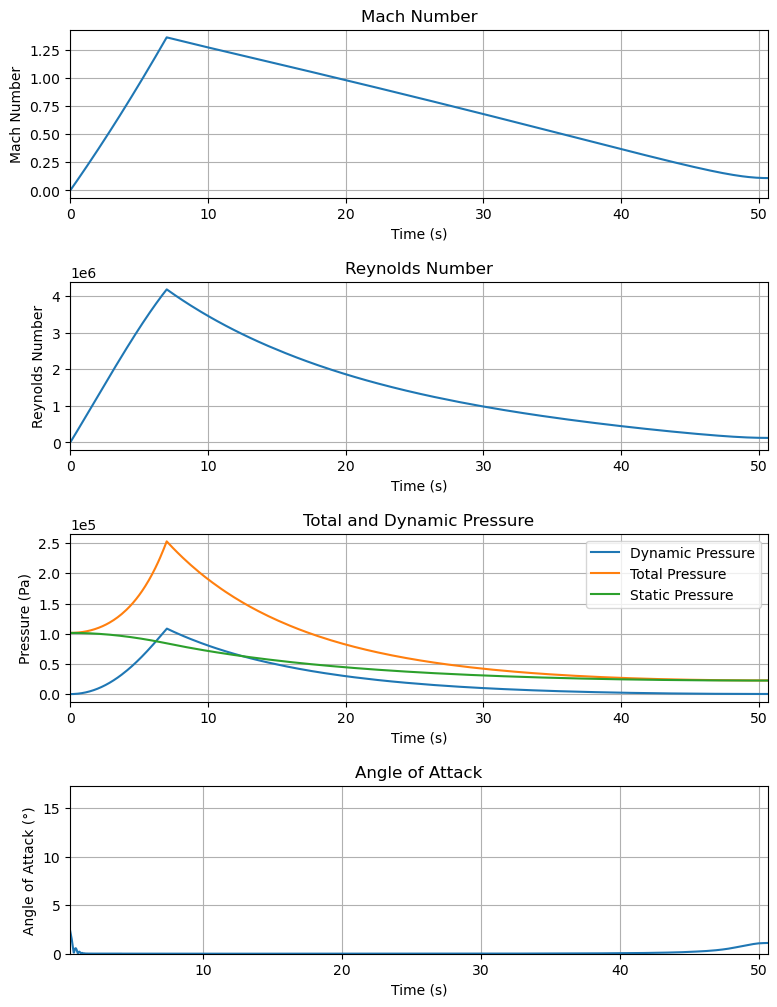



Trajectory Stability and Control Plots



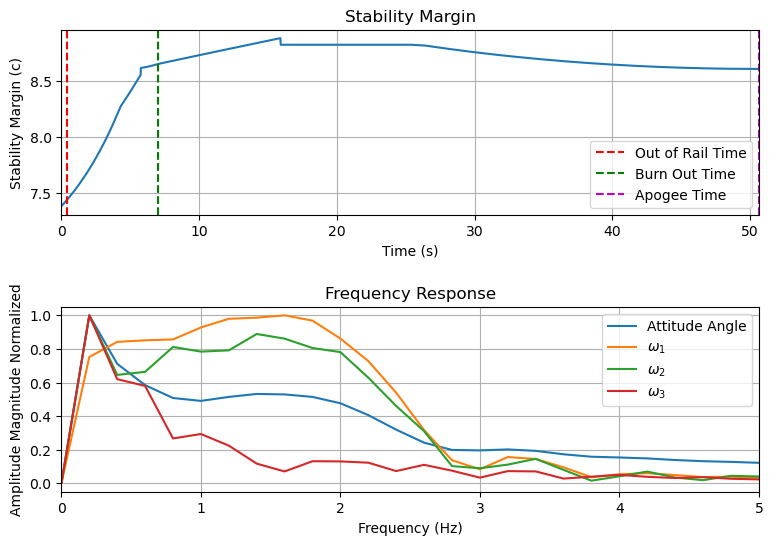



Rocket and Parachute Pressure Plots



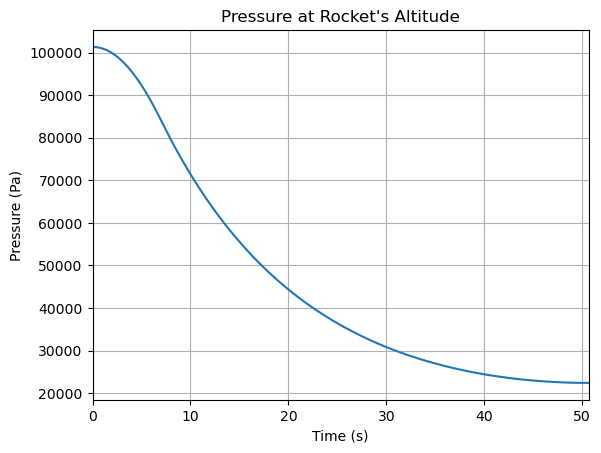


Rocket has no parachutes. No parachute plots available


In [76]:
test_flight.all_info()